In [1]:
%pip install osmnx
%pip install contextily
%pip install networkx

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import osmnx as ox
import contextily

import networkx as nx
import matplotlib.pyplot as plt
import scipy.linalg as la
import numpy as np

In [3]:
north = 49.314886
south = 49.1754210
east = -123.002603
west = -123.267771


bounding_box = (west,south,east,north)

G = ox.graph.graph_from_bbox(bounding_box, network_type = 'drive')

In [4]:
def plot_graph(f,ax,edges):
    edges.plot(linewidth=.25, ax=ax, color='k')
    contextily.add_basemap(ax=ax,
                        crs=edges.crs,
                        source = contextily.providers.CartoDB.Voyager)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

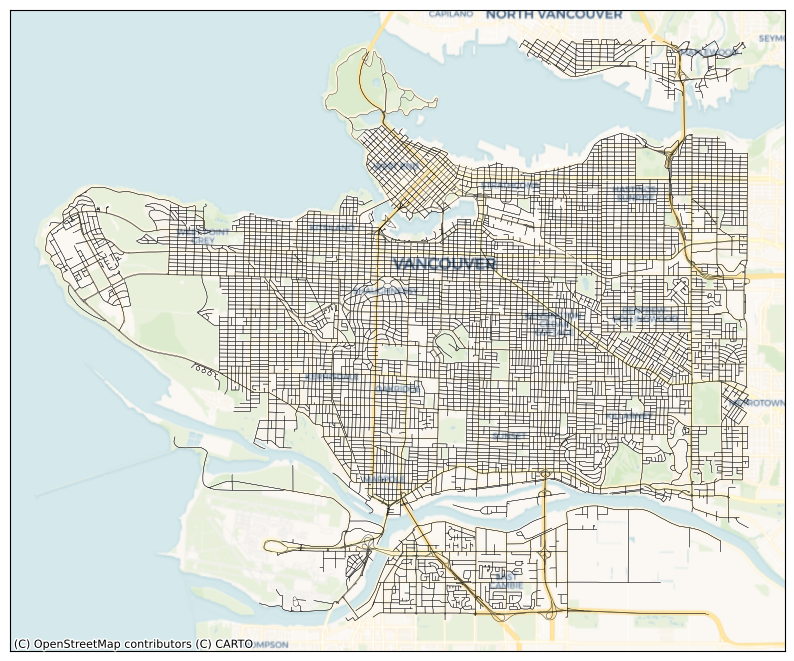

In [5]:
nodes, edges  = ox.graph_to_gdfs(G)

f,ax = plt.subplots(1,1, figsize=(10,10))
plot_graph(f,ax,edges)

In [6]:
stores_downtown = [
    (49.291074726223876, -123.1345112715533),
    (49.285778717275015, -123.1388610469531),
    (49.28543824009544, -123.12140394834859),
    (49.288086333967435, -123.11403832867163),
    (49.28108749140217, -123.12134595134327),
    (49.27953626208601, -123.1155462508102),
    (49.28131449647768, -123.10713668503729)
]

stores_van = [
    (49.26710745424008, -123.24276573624313),
    (49.26495239140005, -123.17770621538237),
    (49.269395328423684, -123.15949483697254),
    (49.264310005956226, -123.13849432853601),
    (49.236563149786534, -123.1543967279795)
]

stores_eastvan = [
    (49.265501224782504, -123.1167840944718),  
    (49.264156985091404, -123.06992053669686),  
    (49.260348107095176, -123.04365634497684),  
    (49.26762952939976, -123.02494525414363),  
    (49.24711277560665, -123.10169652190295),  
    (49.24640207307076, -123.06359221703782),  
    (49.23452058476019, -123.06597739540537),  
    (49.207897379250966, -123.12469600383916),  
    (49.21458384969505, -123.10853491891567),  
    (49.22126941578986, -123.07746972234048),
    (49.272454228734645, -123.1004652050492),  
    (49.281730801002375, -123.03062404165448)
]

storage = [(49.19415257260286, -123.17518597496046)]

stores = storage + stores_downtown + stores_van + stores_eastvan
len(stores)

25

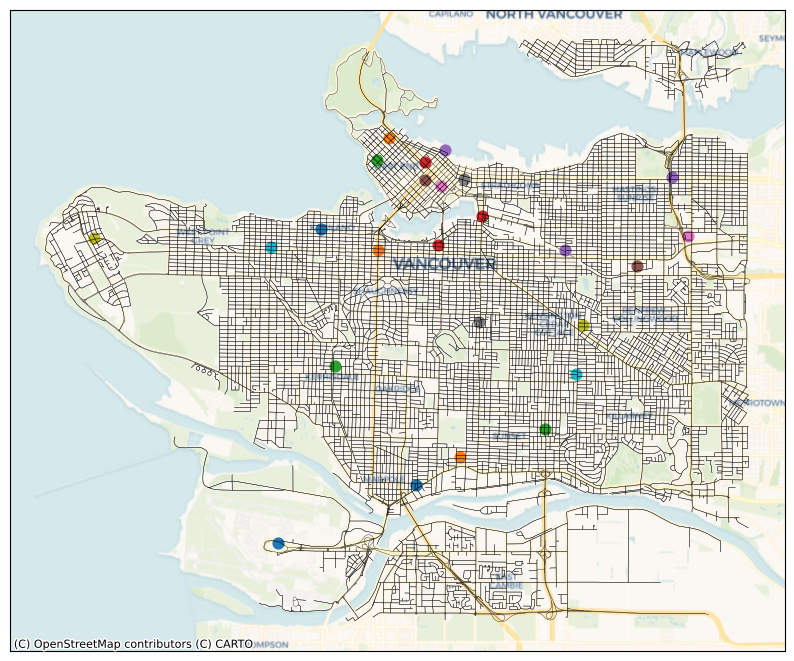

In [7]:
f,ax = plt.subplots(1,1, figsize=(10,12))
plot_graph(f,ax,edges)
for point in stores:
    latitude,longitude = point
    ax.scatter(longitude,latitude,s=60,label = point)
plt.show()

In [8]:
important_nodes = [ox.distance.nearest_nodes(G, point[1],point[0]) 
                   for point in stores]
G = ox.distance.add_edge_lengths(G)

In [9]:
shortest_paths = [[nx.shortest_path(G,node_0,node_1,weight='length') 
                   for node_1 in important_nodes] for node_0 in important_nodes]
shortest_path_lengths = np.array([
    [nx.shortest_path_length(G,node_0,node_1,weight='length') for node_1 in important_nodes]
    for node_0 in important_nodes
])

In [10]:
def get_path_edges(path_nodes,edges):
    edge_list = [(path_nodes[j],path_nodes[j+1]) for j in range(len(path_nodes)-1)]
    return edges[edges.index.isin(edge_list)]

def plot_paths(f,ax,tour,shortest_paths,lwidth):
    for i in range(len(tour)-1):
        shortest_path_edges = get_path_edges(shortest_paths[tour[i]][tour[i+1]],edges)
        shortest_path_edges.plot(linewidth=lwidth, ax=ax, color='b')
    shortest_path_edges = get_path_edges(shortest_paths[tour[-1]][tour[0]],edges)
    shortest_path_edges.plot(linewidth=lwidth, ax=ax, color='b')

def cost_matrix(V):
    n = V.shape[0]
    C = np.zeros((n,n))
    for i in range(1,n):
        for j in range(0,i):
            C[i,j] = np.sqrt((V[j,0] - V[i,0])**2 + (V[j,1] - V[i,1])**2)
            C[j,i] = C[i,j]
    return C

def tour_cost(C,tour):
    n = len(tour)
    cost = 0
    for i in range(n-1):
        cost += C[tour[i],tour[i+1]]
    cost += C[tour[-1],tour[0]]
    return cost

def nearest_neighbor(V,start=0, C = None):
    n = V.shape[0]
    if C is None:
        C = cost_matrix(V)
    tour = [start]
    nodes = list(range(n))
    nodes.remove(start)
    for i in range(1,n):
        next_i = np.argmin(C[tour[-1],nodes])
        next_node = nodes[next_i]
        tour.append(next_node)
        nodes.pop(next_i)
    cost = tour_cost(C,tour)
    return tour,cost

In [11]:
V = np.array(stores)

In [12]:
tour,cost = nearest_neighbor(V,start = 0, C=shortest_path_lengths)
tour_named = [stores[i] for i in tour]
tour_named

[(49.19415257260286, -123.17518597496046),
 (49.207897379250966, -123.12469600383916),
 (49.21458384969505, -123.10853491891567),
 (49.22126941578986, -123.07746972234048),
 (49.23452058476019, -123.06597739540537),
 (49.24640207307076, -123.06359221703782),
 (49.264156985091404, -123.06992053669686),
 (49.260348107095176, -123.04365634497684),
 (49.26762952939976, -123.02494525414363),
 (49.281730801002375, -123.03062404165448),
 (49.28131449647768, -123.10713668503729),
 (49.27953626208601, -123.1155462508102),
 (49.28108749140217, -123.12134595134327),
 (49.28543824009544, -123.12140394834859),
 (49.288086333967435, -123.11403832867163),
 (49.291074726223876, -123.1345112715533),
 (49.285778717275015, -123.1388610469531),
 (49.264310005956226, -123.13849432853601),
 (49.265501224782504, -123.1167840944718),
 (49.272454228734645, -123.1004652050492),
 (49.24711277560665, -123.10169652190295),
 (49.236563149786534, -123.1543967279795),
 (49.26495239140005, -123.17770621538237),
 (49.2

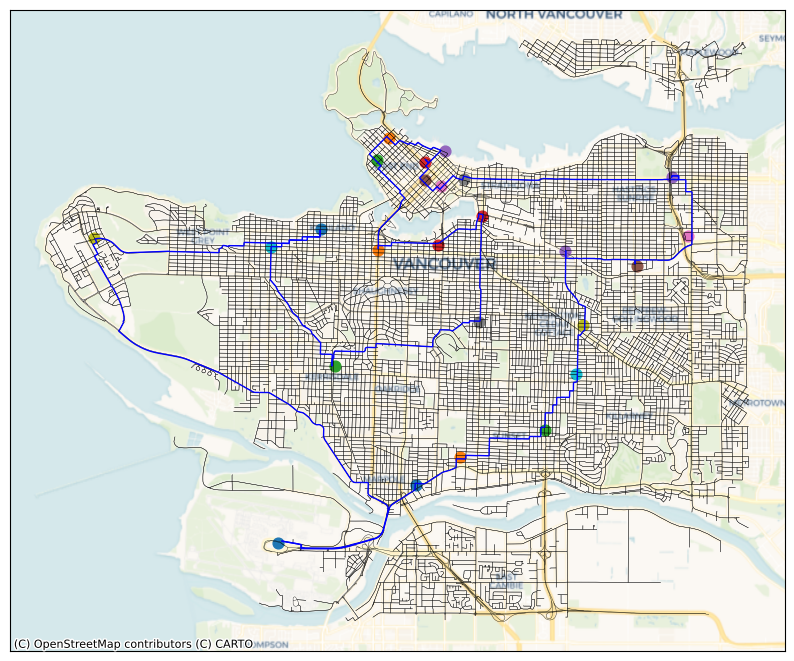

In [13]:
f,ax = plt.subplots(1,1, figsize=(10,10))
plot_graph(f,ax,edges)
for point in stores:
    ax.scatter(point[1],point[0],s=60)
plot_paths(f,ax,tour,shortest_paths,1)
plt.show()

## 2 cars to deliver by alternatively choose the next nearest stores. 

Route for Car 1:
	(49.19415257260286, -123.17518597496046)
	(49.207897379250966, -123.12469600383916)
	(49.22126941578986, -123.07746972234048)
	(49.23452058476019, -123.06597739540537)
	(49.24640207307076, -123.06359221703782)
	(49.264156985091404, -123.06992053669686)
	(49.260348107095176, -123.04365634497684)
	(49.26762952939976, -123.02494525414363)
	(49.281730801002375, -123.03062404165448)
	(49.265501224782504, -123.1167840944718)
	(49.264310005956226, -123.13849432853601)
	(49.269395328423684, -123.15949483697254)
	(49.236563149786534, -123.1543967279795)
	(49.19415257260286, -123.17518597496046)
Total Distance: 45555.68 meters

Route for Car 2:
	(49.19415257260286, -123.17518597496046)
	(49.21458384969505, -123.10853491891567)
	(49.24711277560665, -123.10169652190295)
	(49.272454228734645, -123.1004652050492)
	(49.28131449647768, -123.10713668503729)
	(49.27953626208601, -123.1155462508102)
	(49.28108749140217, -123.12134595134327)
	(49.28543824009544, -123.12140394834859)
	(49

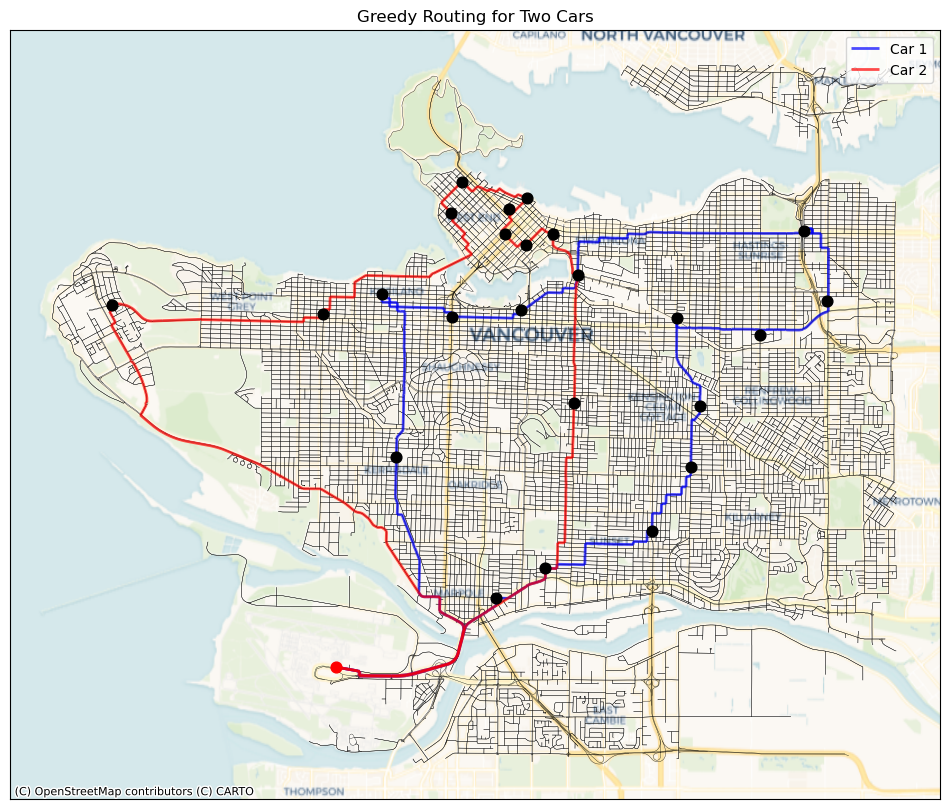

In [14]:
yvr = (49.19415257260286, -123.17518597496046)

all_points = [yvr] + stores_downtown + stores_van + stores_eastvan

all_nodes = [ox.distance.nearest_nodes(G, lon, lat) for lat, lon in all_points]

distance_matrix = np.array([
    [nx.shortest_path_length(G, node_from, node_to, weight='length') 
     for node_to in all_nodes] 
    for node_from in all_nodes
])

# Greedy Algorithm for 2 Cars
def greedy_two_car_routing(dist_matrix):
    n_points = len(dist_matrix)
    unvisited = set(range(1, n_points))  # All except starting node (YVR at index 0)
    routes = [[0], [0]]  # Two cars starting at YVR
    distances = [0, 0]

    car_turn = 0  # Alternate turns between cars
    while unvisited:
        last_point = routes[car_turn][-1]
        # Find nearest unvisited point to current car
        nearest_point = min(unvisited, key=lambda p: dist_matrix[last_point, p])
        # Update route and distances
        routes[car_turn].append(nearest_point)
        distances[car_turn] += dist_matrix[last_point, nearest_point]
        unvisited.remove(nearest_point)
        car_turn = 1 - car_turn  # Switch car turn

    # Return YVR 
    for car in [0, 1]:
        distances[car] += dist_matrix[routes[car][-1], 0]
        routes[car].append(0)

    return routes, distances


routes, distances = greedy_two_car_routing(distance_matrix)

# Visualization
def plot_two_car_routes(G, edges, all_nodes, routes, color_list=['blue', 'red']):
    f, ax = plt.subplots(figsize=(12, 12))
    plot_graph(f, ax, edges)

    # Plot all points
    for idx, node in enumerate(all_nodes):
        point = (G.nodes[node]['y'], G.nodes[node]['x'])
        ax.scatter(point[1], point[0], color='red' if idx == 0 else 'black', s=60, zorder=5)

    # Plot routes for each car
    for car_idx, route in enumerate(routes):
        for i in range(len(route)-1):
            path_nodes = nx.shortest_path(G, all_nodes[route[i]], all_nodes[route[i+1]], weight='length')
            path_edges = get_path_edges(path_nodes, edges)
            path_edges.plot(ax=ax, linewidth=2, color=color_list[car_idx], alpha=0.7, label=f'Car {car_idx+1}' if i==0 else "")

    plt.legend()
    plt.title('Greedy Routing for Two Cars')
    plt.show()

# Display routes clearly
for i, route in enumerate(routes):
    named_route = [all_points[idx] for idx in route]
    print(f"Route for Car {i+1}:")
    for point in named_route:
        print(f"\t{point}")
    print(f"Total Distance: {distances[i]:.2f} meters\n")

plot_two_car_routes(G, edges, all_nodes, routes)